# 1.3.5_overfit_and_underfit

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')

In [6]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type='GZIP')

In [7]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

In [8]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


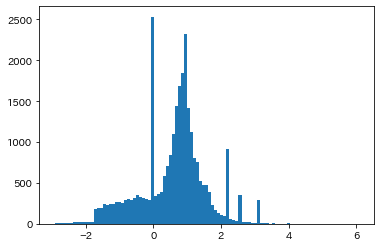

In [9]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [10]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [11]:
validate_ds = packed_ds.take(N_VALIDATION).cache()

In [12]:
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [13]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [14]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [15]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001, 
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

In [16]:
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

Text(0, 0.5, 'learning rate')

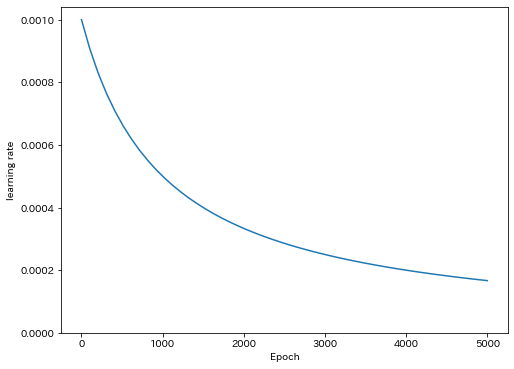

In [22]:
step = np.linspace(0, 1e5)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel("learning rate")

In [23]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]

In [24]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'binary_crossentropy'])
    model.summary()
    
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = max_epochs,
        validation_data = validate_ds,
        callbacks = get_callbacks(name),
        verbose = 0
    )
    
    return history

In [25]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(FEATURES,)),
    layers.Dense(1, activation='sigmoid'),
])

In [26]:
size_histories = {
}

In [27]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5033,  binary_crossentropy:0.7523,  loss:0.7523,  val_accuracy:0.5230,  val_binary_crossentropy:0.7258,  val_loss:0.7258,  
....................................................................................................
Epoch: 100, accuracy:0.6658,  binary_crossentropy:0.6099,  loss:0.6099,  val_accuracy:0.6650,  val_binary_crossentropy:0.6145,  val_loss:0.6145,  
....................................................................................................
Epoch: 200, accuracy:0.68

(0.5, 0.7)

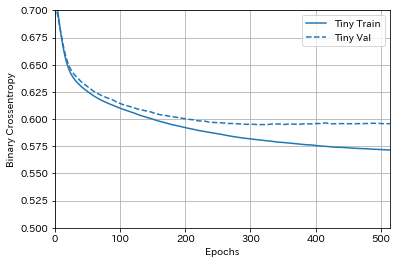

In [29]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [33]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1, activation='sigmoid'),
])
    

In [34]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5051,  binary_crossentropy:0.7151,  loss:0.7151,  val_accuracy:0.5250,  val_binary_crossentropy:0.6994,  val_loss:0.6994,  
....................................................................................................
Epoch: 100, accuracy:0.6757,  binary_crossentropy:0.6046,  loss:0.6046,  val_accuracy:0.6630,  val_binary_crossentropy:0.6081,  val_loss:0.

In [37]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1, activation='sigmoid'),
])
    

In [41]:
size_histories['Medium'] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5183,  binary_crossentropy:0.7152,  loss:0.7152,  val_accuracy:0.5750,  val_binary_crossentropy:0.6772,  val_loss:0.6772,  
....................................................................................................
E

In [42]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1, activation='sigmoid'),
])

In [43]:
size_histories['Large'] = compile_and_fit(large_model, 'sizes/Large')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5204,  binary_crossentropy:0.8080,  loss:0.8080,  val_accuracy:0.5460,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log scale]')

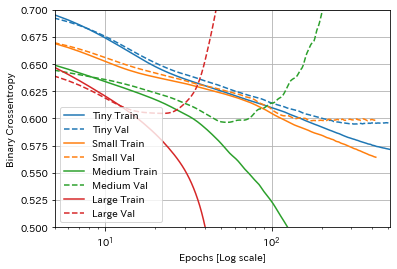

In [44]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel('Epochs [Log scale]')

In [45]:
%tensorboard --logidr {logdir}/sizes

UsageError: Line magic function `%tensorboard` not found.


In [46]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

In [47]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)

In [48]:
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/var/folders/lr/y3b61w391ldgpfc53_x3y9x00000gp/T/tmpx2uqo138/tensorboard_logs/regularizers/Tiny')

In [49]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [50]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), ),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), ),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), ),
    layers.Dense(1, activation='sigmoid'),
])

In [51]:
regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5246,  binary_crossentropy:0.8112,  loss:2.3371,  val_accuracy:0.5420,  val_binary_crossentr

(0.5, 0.7)

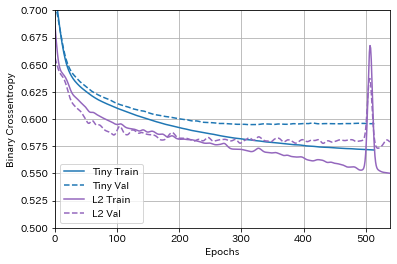

In [52]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [53]:
result = l2_model(features)
regularization_loss = tf.add_n(l2_model.losses)

In [54]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu', ),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu', ),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu', ),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

In [55]:
regularizer_histories['dropput'] = compile_and_fit(dropout_model, 'regularizers/dropout')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)              

(0.5, 0.7)

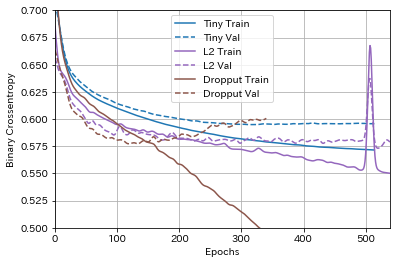

In [56]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [57]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), ),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), ),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), ),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

In [58]:
regularizer_histories['combined'] = compile_and_fit(combined_model, 'regularizers/combined')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)              

(0.5, 0.7)

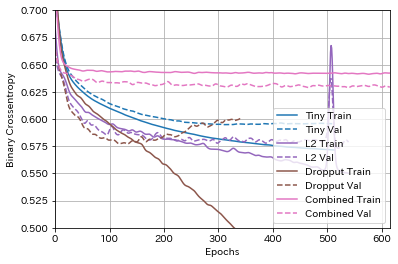

In [61]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [60]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")